In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gammapy.spectrum.models import PowerLaw, PowerLaw2, LogParabola,ExponentialCutoffPowerLaw
from astropy import units as u
from scipy.stats import norm as normal
from scipy.special import ndtri, erf
from scipy.interpolate import UnivariateSpline as USpline
from scipy.interpolate import interp1d
from astropy import constants

For the notebook to run, you will need to install my EBL module, which you can install via 
```pip install ebltable```

In [2]:
from ebltable.tau_from_model import OptDepth

In [3]:
%matplotlib inline

### Import data 

In [4]:
ul_hess = {}
#ul_hess['oct'] = np.loadtxt('../data/upperocto.txt').T
#ul_hess['sept'] = np.loadtxt('../data/uppersept.txt').T
ul_hess['oct'] = np.loadtxt('../data/october17_reanalysis_SpectrumUpperLimitSubmit.txt').T
ul_hess['sept'] = np.loadtxt('../data/september17_reanalysis_SpectrumUpperLimit.txt').T
ul_hess['apr'] = np.loadtxt('../data/apr2016_newmodel_upperlimit.txt').T

### Define Fermi Spectra

In [5]:
fermi_spec = {}
fermi_par = {}

fermi_par['sept'] = dict( pl2 = dict(index = 2.082, amplitude=1.06e-6* u.Unit('cm-2 s-1'),
                              emin = 0.1 * u.GeV, emax = 500. * u.GeV))

fermi_par['sept_sim'] = {}

fermi_par['oct'] = dict( pl2 = dict(index = 2.242, amplitude=3.12e-7 * u.Unit('cm-2 s-1'),
                             emin = 0.1 * u.GeV, emax = 500. * u.GeV))

norm = 1e-11
fermi_par['sept_sim']['pl'] = dict(index = 2.005, amplitude=23.32*norm* u.Unit(
                                    'MeV-1 cm-2 s-1').to('GeV-1 cm-2 s-1'),
                              reference = 0.496426 * u.GeV)
fermi_par['sept']['pl'] = dict(index = 2.082, amplitude=40.97757589849*norm* u.Unit(
                                    'MeV-1 cm-2 s-1').to('GeV-1 cm-2 s-1'),
                              reference = 0.496426 * u.GeV)
fermi_par['oct']['pl'] =  dict(index = 2.242, amplitude=10.65170752054*norm * u.Unit(
                                    'MeV-1 cm-2 s-1').to('GeV-1 cm-2 s-1'),
                             reference = 0.496426 * u.GeV)
fermi_par['sept']['lp'] = dict(alpha = 2.009289714868, 
                               amplitude=43.01704086633*norm* u.Unit(
                                    'MeV-1 cm-2 s-1').to('GeV-1 cm-2 s-1'),
                               beta = 0.05727591104931,
                              reference = 0.496426 * u.GeV)
fermi_par['oct']['lp'] =  dict(alpha = 2.150070906498,
                               amplitude=12.46879700208*norm * u.Unit(
                                    'MeV-1 cm-2 s-1').to('GeV-1 cm-2 s-1'),
                               beta = 0.1585455831175,
                             reference = 0.496426 * u.GeV)


fermi_spec['sept'] = dict(pl2 = PowerLaw2(**fermi_par['sept']['pl2']))
fermi_spec['sept_sim'] = {}
fermi_spec['oct'] = dict(pl2 = PowerLaw2(**fermi_par['oct']['pl2']))

fermi_spec['sept']['pl'] = PowerLaw(**fermi_par['sept']['pl'])
fermi_spec['sept_sim']['pl'] = PowerLaw(**fermi_par['sept_sim']['pl'])
fermi_spec['oct']['pl'] = PowerLaw(**fermi_par['oct']['pl'])

fermi_spec['sept']['lp'] = LogParabola(**fermi_par['sept']['lp'])
fermi_spec['oct']['lp'] = LogParabola(**fermi_par['oct']['lp'])

Init covariance matrices (obtained from https://hess-confluence.desy.de/confluence/x/HepLAQ)

In [6]:
cov = dict(
    sept = dict(
        pl = np.array([
            [2.70846, -0.000634053],
            [-0.000634053, 0.00123528]]),
        lp = np.array([
            [4.44714,   -0.0286326,    0.0286135],
            [-0.0286326,    0.0022752, -0.000666179],
            [0.0286135, -0.000666179,  0.000619096]
            ])
    ), 
    sept_sim = dict(
        pl = np.array([
            [      8.23102,    0.0703009],
            [0.0703009,   0.00987797 ]]),
    ), 
    oct = dict(
        pl = np.array([
            [5.0838, -0.0261991],
            [-0.0261991, 0.0377177]]),
        lp = np.array([
            [10.2542,    -0.143369,     0.326844],
            [-0.143369,     0.065213,   -0.0122297],
            [0.326844,   -0.0122297,     0.033347]
        ])
    )
)

for k in list(cov.keys()):
    for s in list(cov[k].keys()):
        cov[k][s][0] *= norm
        cov[k][s][:,0] *= norm

In [7]:
z = 1.388
tau = OptDepth.readmodel(model='dominguez')

### Define butterfly functions

In [8]:
butterfly_pl = lambda x,cov,**p : np.sqrt (cov[0,0]/p['amplitude'] ** 2. + \
                    np.log(x/p['reference'])**2. * cov[1,1] \
                    + 2. * cov[0,1] * np.log(x/p['reference']) / p['amplitude']
                    )
butterfly_lp = lambda x,cov,**p : np.sqrt( cov[0,0]/p['norm'] ** 2. \
            + 2. * cov[0,1] * np.log(x/p['Eb']) / p['norm'] \
            + np.log(x / p['Eb'] ) **2. * ( \
            cov[1,1] + cov[2,2] * np.log(x/p['Eb']) ** 2. \
            + 2. * (cov[0,2] / p['norm'] + cov[1,2] * np.log(x/p['Eb']) ) \
            )
            )

### Plot

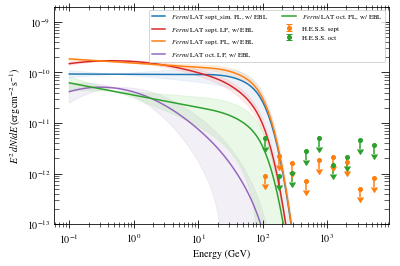

In [9]:
ax = plt.gca()

x = np.logspace(-1, 3.5,100) * u.GeV
for i,k in enumerate(list(fermi_par.keys())):
    
    if k in ul_hess.keys():    
        ax.errorbar(ul_hess[k][0] * 1e3, ul_hess[k][1] * ul_hess[k][0]**2. * \
                        1e3 * 1e-4 *u.GeV.to('erg'),
               yerr = np.array([ul_hess[k][1] / 3.,np.zeros_like(ul_hess[k][1])]) * \
                    ul_hess[k][0]**2. * 1e3 * 1e-4*u.GeV.to('erg'),
               uplims = True, 
               marker = 'o',
               ms = 4.,
               ls = 'None',
               color = plt.cm.tab20(0.1 * i),
               label = 'H.E.S.S. {0:s}'.format(k))

    for j,s in enumerate(list(fermi_spec[k].keys())):
        #print (k,s,fermi_spec.keys())
        if s == 'pl2': continue
            
        f = fermi_spec[k][s](x)
        c = u.GeV.to('erg') * x ** 2.
        atten = np.exp(-tau.opt_depth(z,x.value / 1e3))
        col = 0. if s == 'pl' else 0.2
        
        if s == 'pl' or s == 'lp':
            df = butterfly_pl(x,cov[k][s],**fermi_par[k][s])
            
            ax.fill_between(x, f * (1. + df)* c * atten, 
                            y2 = f* (1. - df) * c * atten, 
                            color = plt.cm.tab20(0.1 * i + 0.05 + col),
                           alpha = 0.2)
            
        ax.plot(x, f * c * atten,
            color = plt.cm.tab20(0.1 * i + col),
           ls = '-',
           label = '$Fermi$ LAT {0:s}. {1:s}, w/ EBL'.format(k,s.upper()))

ax.legend(loc = 'upper right', fontsize = 'x-small', ncol = 2)
ax.set_ylim(1e-13,2e-9)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('$E^2\,dN/dE\,(\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1})$')
plt.savefig('./sed.pdf')
plt.savefig('./sed.png')

# Modifying the extrapolation with exponential cut-off, stronger EBL, BLR absorption

First we define which combination of HESS upper limits and Fermi spectra to use:

In [10]:
h = 'sept' # HESS UL set
f = 'sept_sim' # Fermi spectra set
fs = 'pl' # Fermi spectrum and parameters

And the $\Delta$TS value for a 95% C.L. limit for 1 d.o.f. 

In [11]:
deltats = 2.71

Create a set of likelihood functions vs flux from the HESS upper limits. Done with a function adapted from https://github.com/me-manu/blrabsorption/blob/master/fit_blr.py

In [12]:
erfnorm = lambda z1,z0,x0,sigma: 0.5 * \
                    (erf((z1 - x0)/np.sqrt(2. * sigma**2.)) - \
                    erf((z0 - x0)/np.sqrt(2. * sigma**2.)))
    
def get_llh(x,y,dy, mUL, scale = 5., ysteps = 400, ymin = 1e-15, 
    ULconf = 0.95, distr = 'norm'):
    """
    Initialize the class by building a data likelihood cube 
    from x (EGeV) and y (dN/dE) data with statistical error dy
    Parameters
    ----------
    x: `~numpy.ndarray`
        n-dim array with energy values in GeV
    y: `~numpy.ndarray`
        n-dim array with flux values 
    dy: `~numpy npdarray`
        n-dim array with statistical uncertainties on flux values
    mUL: `~numpy npdarray`
        n-dim array with bools that are true if y in the bin is upper limit

    {options}
    scale: float
        numbers of sigmas for likelihood scan
        
    ysteps: int
        number of steps for likelihood scan
    ymin: float
        minimum flux assumed for likelihood scan
        
    ULconf: float
        confidence interval for upper limit
    """
    ymin = np.min((ymin, np.min(np.abs(y - scale * dy))))
    ymax = np.max(y + scale * dy)
    yrange = np.logspace(np.log10(ymin), np.log10(ymax), ysteps)

    llh = []
    for i,E in enumerate(x):
        if mUL[i]:
            llh.append(normal.pdf(yrange, loc = ymin, scale = dy[i] / ndtri(ULconf)))
            print ("assuming {0:.3f} confidence level".format(
                    erfnorm(dy[i], 0.,0., dy[i] / ndtri(ULconf)) + 0.5
                    ))
        else:
            if distr == 'norm':
                llh.append(normal.pdf(yrange, loc = y[i], scale = dy[i]))
            elif distr == 'lognorm':
                sigma = np.sqrt(np.log(1. + dy[i]**2. / y[i]**2.))
                llh.append(lognorm.pdf(yrange / y[i], sigma))

        llh[-1][llh[-1] < 1e-200] = np.ones(np.sum(llh[-1] < 1e-200)) * 1e-200

    return np.log(llh), yrange

In [13]:
llh, yrange = get_llh(x = ul_hess[h][0],
              dy = ul_hess[h][1] * ul_hess[h][0]**2. * \
                        1e3 * 1e-4 *u.GeV.to('erg'),
              y = np.zeros_like(ul_hess[h][0]),
              mUL = np.ones(ul_hess[h][0].size, dtype = np.bool),
              ymin = 1e-13,
              ULconf = 0.95,
              distr = 'norm'
             )

assuming 0.950 confidence level
assuming 0.950 confidence level
assuming 0.950 confidence level
assuming 0.950 confidence level
assuming 0.950 confidence level
assuming 0.950 confidence level
assuming 0.950 confidence level
assuming 0.950 confidence level
assuming 0.950 confidence level


Plot the likelihood curves for each energy bin:

Text(0,0.5,u'TS')

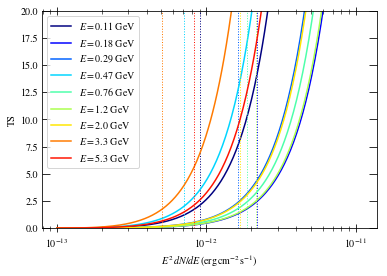

In [14]:
cp = plt.cm.jet
for i,l in enumerate(llh):
    plt.semilogx(yrange,-2. * (l - np.max(l)), 
                color = cp(i / float(len(llh))), label = '$E = {0:.2}$ GeV'.format(ul_hess[k][0][i]))
    plt.axvline((ul_hess[h][1] * ul_hess[h][0]**2. * \
                        1e3 * 1e-4 *u.GeV.to('erg'))[i],
               color = cp(i / float(len(llh))), lw = 1 , ls = ':')
plt.gca().set_ylim(0,20.)
plt.legend(loc = 0)
plt.xlabel('$E^2\,dN/dE\,(\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1})$')
plt.ylabel('TS')

Interpolate the likelihood curves:

In [15]:
interp_llh = interp1d(np.log10(yrange), llh, kind='linear', fill_value='extrapolate')

### Extrapolate with exponential cut-off:

In [16]:
fermi_par[f][fs].update({"lambda_" : 1. / 1e5}) # large starting value for cut-off energy

In [17]:
spec = ExponentialCutoffPowerLaw(**fermi_par[f][fs])

loop over exponential cut-off values and record likelihood

In [18]:
cut_off = np.logspace(3., 1., 100)

sum_llh = np.zeros_like(cut_off)

atten = np.exp(-tau.opt_depth(z,ul_hess[h][0]))

for i, c in enumerate(cut_off):
    spec.parameters['lambda_'].value = 1. / c
    y = (spec(ul_hess[h][0] * 1e3) * (ul_hess[h][0] * 1e3)** 2. * u.GeV.to('erg')).value * atten
    sum_llh[i] = np.diag(interp_llh(np.log10(y))).sum() # the diag command returns likelihood value of bin i for flux in bin i

Plot the summed likelihood 

(-1, 20)

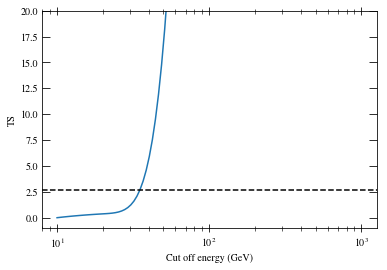

In [19]:
plt.semilogx(cut_off, -2 * (sum_llh - sum_llh.max()))
plt.axhline(deltats, color = 'k', ls = '--')
plt.xlabel("Cut off energy (GeV)")
plt.ylabel("TS")
plt.gca().set_ylim(-1,20)

And print the upper limit on the cut off energy

In [20]:
ts_inv = interp1d(-2 * (sum_llh - sum_llh.max()), np.log(cut_off), kind = 'linear')

In [21]:
print ("One sided 95% upper limit cut-off energy: E_cut < {0:.2f} GeV".format(np.exp(ts_inv(deltats))))

One sided 95% upper limit cut-off energy: E_cut < 35.08 GeV


At the end, remove exponential cut-off again from parameter dict

In [22]:
fermi_par[f][fs].pop("lambda_", None)

1e-05

### Extrapolate with different EBL density 

Loop over EBL density normalization 

In [23]:
nebl = np.linspace(1., 4., 100)

sum_llh = np.zeros_like(nebl)

for i, n in enumerate(nebl):
    atten = np.exp(-n * tau.opt_depth(z,ul_hess[h][0]))
    y = (fermi_spec[f][fs](ul_hess[h][0] * 1e3) * (ul_hess[h][0] * 1e3)** 2. * u.GeV.to('erg')).value * atten
    sum_llh[i] = np.diag(interp_llh(np.log10(y))).sum() # the diag command returns likelihood value of bin i for flux in bin i

Plot the summed likelihood 

(-1, 50)

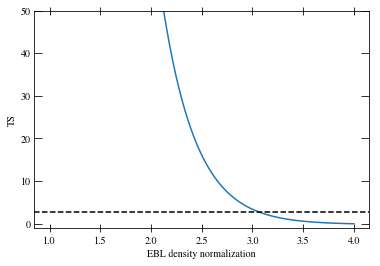

In [24]:
plt.plot(nebl, -2 * (sum_llh - sum_llh.max()))
plt.axhline(deltats, color = 'k', ls = '--')
plt.xlabel("EBL density normalization")
plt.ylabel("TS")
plt.gca().set_ylim(-1,50)

And print the lower limit on the EBL density

In [25]:
ts_inv = interp1d(-2 * (sum_llh - sum_llh.max()), nebl, kind = 'linear')

In [26]:
print ("One sided 95% lower limit on EBL density scaling: n_EBL > {0:.2f}".format(ts_inv(deltats)))

One sided 95% lower limit on EBL density scaling: n_EBL > 3.07


### Extrapolate with absorption in BLR

For this to work you need to clone this github repo and add it to your python path: https://github.com/me-manu/blrabsorption

In [27]:
from blrabsorption import absorption as ab

Initiate the BLR absorption class

In [28]:
Ldisk = 1e46 # assumed disk luminsosity in erg / s -> do we have better values?
M_BH = 1e9 # assumed black hole mass in solar masses -> do we have better values?
LHbeta = 1e43 # assumed HBeta luminosity in erg / s -> do we have better values?
r_g = constants.G * M_BH * constants.M_sun / constants.c**2. # gravitational radius

In [29]:
blr = ab.BLR(Ldisk, z,  lumiHbeta = LHbeta, M_BH = M_BH)

print radius of Ly$\alpha$ emitting ring, $R_{\mathrm{Ly}\alpha} \approx R_\mathrm{BLR}$

In [30]:
idx = blr.blr_lines['Ion'] == 'Ly alpha'
RLyalpha = blr.Rli[idx][0]
print ("R_Lyalpha ~ R_BLR = {0:.2e} cm".format(RLyalpha))

R_Lyalpha ~ R_BLR = 5.88e+16 cm


Calculate the absorption in the ring geometry in the galaxy frame

In [31]:
EGeV = ul_hess[h][0] * (1. + z) * 1e3
Rcm = np.logspace(-1.,1.5,51) * RLyalpha

tauRing = blr.tau(EGeV, Rcm, geometry = 'ring',
            lsteps = 100, mu_steps=100, 
            rtilde_max = 1e12
            )
print (tauRing.shape)

(9, 51, 26)


loop over the different values of the distance between black hole and $\gamma$-ray emitting region

In [32]:
sum_llh = np.zeros_like(Rcm)

for i, r in enumerate(Rcm):
    atten = np.exp(-(tauRing.sum(axis = -1)[:,i] + tau.opt_depth(z,ul_hess[h][0]))) # sum over all absorption lines
    y = (fermi_spec[f][fs](ul_hess[h][0] * 1e3) * (ul_hess[h][0] * 1e3)** 2. * u.GeV.to('erg')).value * atten
    sum_llh[i] = np.diag(interp_llh(np.log10(y))).sum() # the diag command returns likelihood value of bin i for flux in bin i

Plot the summed likelihood 

(-1, 50)

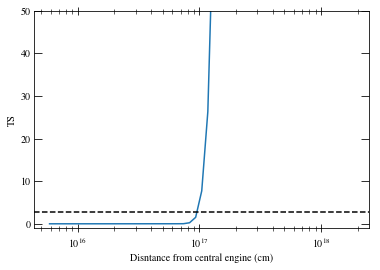

In [33]:
plt.semilogx(Rcm, -2 * (sum_llh - sum_llh.max()))
plt.axhline(deltats, color = 'k', ls = '--')
plt.xlabel("Disntance from central engine (cm)")
plt.ylabel("TS")
plt.gca().set_ylim(-1,50)

And print the upper limit on the distance

In [34]:
ts_inv = interp1d(-2 * (sum_llh - sum_llh.max()), np.log(Rcm), kind = 'linear')

In [35]:
rlim = np.exp(ts_inv(deltats))
print ("One sided 95% upper limit on distance: R < {0:.2e} cm = {1:.2f} RLyalpha = {2:.2f} rg".format(
    rlim, rlim / RLyalpha, (rlim / r_g.to('cm')).value))

One sided 95% upper limit on distance: R < 9.53e+16 cm = 1.62 RLyalpha = 645.34 rg
